<a href="https://colab.research.google.com/github/mrdbourke/airbnb-object-detection/blob/wip/05-detectron2-experiment-tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectron2 Experiment Tracking Notebook

This notebook builds upon the Detectron2 small model building notebook.

The goal with this one is to create a way to track my Detectron2 model building experiments using [Weights & Biases](https://www.wandb.com).

Previous notebook: https://drive.google.com/open?id=1bw5xIfyKGh-tT43PPoyePPME3TS3CYMY

I'm going to work on merging the previous notebook with:
- [Detectron2's plain_train_net.py](https://github.com/facebookresearch/detectron2/blob/master/tools/plain_train_net.py)
- [Weights & Biases example PyTorch notebook](https://colab.research.google.com/drive/11wUb0v1_1CxcTYD6-LxRY51ozZyrdbk8#scrollTo=bZpt5W2NNl6S)

Original Detectron2 tutorial: https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

+

<img src="https://i.imgur.com/1oTyk79.png" width="500">


# Install detectron2

In [0]:
# # install dependencies: (use cu100 because colab is on CUDA 10.0)
# !pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
# !pip install cython pyyaml==5.1
# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# # install detectron2:
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

# # WandB - Install the W&B library
# !pip install wandb -q

# print("#### Versions: ####")
# import torch, torchvision
# torch.__version__
# !gcc --version
# # opencv is pre-installed on colab

In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import os
import pandas as pd
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# wandb - Import weight's & biases
import wandb

import torch, torchvision
print(torch.__version__)
!gcc --version
# opencv is pre-installed on colab

1.4.0+cu100
gcc (Ubuntu 7.4.0-1ubuntu1~18.04.1) 7.4.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [0]:
# # wandb - Login to wandb account so all metrics can be logged
# !wandb login

# Setup Custom Dataset

TODO - add annotations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Setup training and validation data paths
train_path = "/content/drive/My Drive/Airbnb/coffeemaker-train"
valid_path = "/content/drive/My Drive/Airbnb/coffeemaker-validation"

**Note:** You only need to run the cell below once.

In [0]:
# # Download required meta-files for V5 - https://storage.googleapis.com/openimages/web/download.html

# # Training bounding boxes (1.11G)
# !wget https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv

# # Validating bounding boxes (23.94M)
# !wget https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv
    
# # Testing bounding boxes (73.89M)
# !wget https://storage.googleapis.com/openimages/v5/test-annotations-bbox.csv

# # Class Names (11.73K)
# !wget https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv

In [0]:
# Classes of amenities Airbnb mostly cares about
subset = ["Toilet",
          "Swimming_pool",
          "Bed",
          "Billiard_table",
          "Sink",
          "Fountain",
          "Oven",
          "Ceiling_fan",
          "Television",
          "Microwave_oven",
          "Gas_stove",
          "Refrigerator",
          "Kitchen_&_dining_room_table",
          "Washing_machine",
          "Bathtub",
          "Stairs",
          "Fireplace",
          "Pillow",
          "Mirror",
          "Shower",
          "Couch",
          "Countertop",
          "Coffeemaker",
          "Dishwasher",
          "Sofa_bed",
          "Tree_house",
          "Towel",
          "Porch",
          "Wine_rack",
          "Jacuzzi"]

In [0]:
def get_image_ids(image_folder=None):
    """
    Explores a folder of images and gets their ID from their file name.
    Returns a list of all image ID's in image_folder.
    E.g. image_folder/608fda8c976e0ac.jpg -> ["608fda8c976e0ac"]
    
    Params
    ------
    image_folder (str): path to folder of images, e.g. "../validation/"
    """
    return [os.path.splitext(img_name)[0] for img_name in os.listdir(image_folder)]

In [0]:
# Make a function which formats a specific annotations csv based on what we're dealing with
def format_annotations(image_folder, annotation_file, target_classes=None):
    """
    TODO - NOTE: This function could (definitely can) be faster.
    TODO - Some ideas: skip the use of pandas entirely and use CSV's
    
    Formats annotation_file based on images contained in image_folder.
    Will get all unique image IDs and make sure annotation_file
    only contains those (the target images).
    Adds meta-data to annotation_file such as class names and categories.
    If target_classes isn't None, the returned annotations will be filtered by this list.
    Note: image_folder and annotation_file should both be validation if working on
    validation set or both be training if working on training set.
    
    Params
    ------
    image_folder (str): path to folder of target images.
    annotation_file (str): path to annotation file of target images.
    target_classes (list), optional: a list of target classes you'd like to filter labels.
    """
    # Get all image ids from target directory
    image_ids = get_image_ids(image_folder)
    
    # Setup annotation file and classnames
    # TODO - improve this, is pandas required? 
    annot_file = pd.read_csv(annotation_file)
    classes = pd.read_csv("class-descriptions-boxable.csv",
                          names=["LabelName", "ClassName"])
    
    # Create classname column on annotations which converts label codes to string labels
    annot_file["ClassName"] = annot_file["LabelName"].map(classes.set_index("LabelName")["ClassName"])
    
    # TODO - fix this, Make sure we only get the images we're concerned about
    if target_classes:
        annot_file = annot_file[annot_file["ImageID"].isin(image_ids) & annot_file["ClassName"].isin(target_classes)]
    else:
        annot_file = annot_file[annot_file["ImageID"].isin(image_ids)]
   
    # Add ClassID column, e.g. "Bathtub, Toilet" -> 1, 2
    annot_file["ClassID"] = pd.Categorical(annot_file["ClassName"]).codes
    
    return annot_file

In [0]:
valid_annots

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,ClassName
0,0001eeaf4aed83f9,xclick,/m/0cmf2,1,0.022673,0.964200,0.071038,0.800546,0,0,0,0,0,Airplane
1,000595fe6fee6369,xclick,/m/02wbm,1,0.000000,1.000000,0.000000,1.000000,0,0,1,0,0,Food
2,000595fe6fee6369,xclick,/m/02xwb,1,0.141384,0.179676,0.676275,0.731707,0,0,0,0,0,Fruit
3,000595fe6fee6369,xclick,/m/02xwb,1,0.213549,0.253314,0.299335,0.354767,1,0,0,0,0,Fruit
4,000595fe6fee6369,xclick,/m/02xwb,1,0.232695,0.288660,0.490022,0.545455,1,0,0,0,0,Fruit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303975,ffff21932da3ed01,xclick,/m/03fp41,1,0.178125,0.710938,0.412500,0.579167,0,0,1,0,0,Houseplant
303976,ffff21932da3ed01,xclick,/m/01g317,1,0.000000,0.015625,0.345833,0.414583,0,1,0,1,0,Person
303977,ffff21932da3ed01,xclick,/m/01g317,1,0.062500,0.085938,0.431250,0.529167,1,0,0,0,0,Person
303978,ffff21932da3ed01,xclick,/m/0c9ph5,1,0.323437,0.409375,0.464583,0.554167,0,0,1,0,0,Flower


In [0]:
def rel_to_absolute(bbox, height, width):
    """
    Converts bounding box dimensions from relative to absolute pixel values (Detectron2 style).
    See: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.BoxMode
    
    Params
    ------
    bbox (array): relative dimensions of bounding box in format (x0, y0, x1, y1 or Xmin, Ymin, Xmax, Ymax)
    height (int): height of image
    width (int): width of image
    """
    bbox[0] = np.round(np.multiply(bbox[0], width)) # x0
    bbox[1] = np.round(np.multiply(bbox[1], height)) # y0
    bbox[2] = np.round(np.multiply(bbox[2], width)) # x1
    bbox[3] = np.round(np.multiply(bbox[3], height)) # y1
    return [i.astype("object") for i in bbox] # convert all to objects for JSON saving

In [0]:
# Import CV2 for getting height & width of image
import cv2

# Import Detectron2 BoxMode for bounding boxes style
from detectron2.structures import BoxMode

In [0]:
# Next: functionise the below code
def get_image_dicts(image_folder):
    """
    Returns Detectron2 style labels of images in image_folder based on data in annotations.
    
    TODO -- Maybe create some verbosity here? AKA, what are the outputs?
    TODO -- what if annotations = None? Can we create a call to create an annotations CSV in 1 hit?
    
    Params
    ------
    image_folder (str): target folder containing images
    annotations (DataFrame): DataFrame of image label data
    """
    annot_file = "validation" if "valid" in image_folder else "train"
    print(f"Using {annot_file} for annotations...")
    # Get annotations (automatically picks annotations CSV based on image_folder)
    annotations = format_annotations(image_folder, 
                                     annot_file+"-annotations-bbox.csv",  # TODO: change for train/val
                                     target_classes=subset) # TODO: this uses a global variable
    
    # TODO: Make sure to only use "Coffeemaker" class - FIX THIS Janky code!
    annotations = annotations[annotations["ClassName"] == "Coffeemaker"]

    print(f"On dataset: {annot_file}")
    print("Classes we're using: {}".format(annotations["ClassName"].value_counts()))

    # Get all unique image ids from target folder
    img_ids = get_image_ids(image_folder)
    
    # Start creating image dictionaries (Detectron2 style labelling)
    img_dicts = []
    for idx, img in enumerate(img_ids):
        record = {}
        
        # Get image metadata
        file_name = image_folder + "/" + img + ".jpg"
        height, width = cv2.imread(file_name).shape[:2]
        img_data = annotations[annotations["ImageID"] == img].reset_index() # reset index important for images
                                                                            # with multiple objects
        # Update record dictionary
        record["file_name"] = file_name
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        
        # Create list of image annotations (labels)
        img_annotations = []
        for i in range(len(img_data)): # this is where we loop through examples with multiple objects in an image
            category_id = img_data.loc[i]["ClassID"].astype("object") # JSON (for evalution) can't take int8 (NumPy type) must be native Python type
            # Get bounding box coordinates in Detectron2 style (x0, y0, x1, y1)
            bbox = np.float32(img_data.loc[i][["XMin", "YMin", "XMax", "YMax"]].values) # needs to be float/int
            # Convert bbox from relative to absolute pixel dimensions
            bbox = rel_to_absolute(bbox=bbox, height=height, width=width)
            # Setup annot (1 annot = 1 label, there might be more) dictionary
            annot = {
                "bbox": bbox, 
                "bbox_mode": BoxMode.XYXY_ABS, # See: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.BoxMode.XYXY_ABS
                "category_id": category_id
            }
            img_annotations.append(annot)
            
        # Update record dictionary with annotations
        record["annotations"] = img_annotations
        
        # Add record dictionary with image annotations to img_dicts list
        img_dicts.append(record)
    return img_dicts

In [0]:
train_path, valid_path

('/content/drive/My Drive/Airbnb/coffeemaker-train',
 '/content/drive/My Drive/Airbnb/coffeemaker-validation')

In [0]:
%%time
train_img_dicts = get_image_dicts(train_path)
val_img_dicts = get_image_dicts(valid_path)
len(val_img_dicts), len(train_img_dicts)

Using train for annotations...
On dataset: train
Classes we're using: Coffeemaker    323
Name: ClassName, dtype: int64
Using validation for annotations...
On dataset: validation
Classes we're using: Coffeemaker    21
Name: ClassName, dtype: int64
CPU times: user 20.3 s, sys: 3.09 s, total: 23.4 s
Wall time: 4min 1s


In [0]:
# # Dump label files to JSON
# import json

# with open("train-coffeemaker-labels.json", "w") as fp:
#   json.dump(train_img_dicts, fp)

# with open("val-coffeemaker-labels.json", "w") as fp:
#   json.dump(val_img_dicts, fp)

In [0]:
# Load annotations from JSON
import json
with open("train-coffeemaker-labels.json", "r") as fp:
  train_img_dicts = json.load(fp)

with open("val-coffeemaker-labels.json", "r") as fp:
  val_img_dicts = json.load(fp)

val_img_dicts[0], train_img_dicts[0]

({'annotations': [{'bbox': [185.0, 9.0, 800.0, 1024.0],
    'bbox_mode': 0,
    'category_id': 0}],
  'file_name': '/content/drive/My Drive/Airbnb/coffeemaker-validation/aa9b35d1bee25627.jpg',
  'height': 1024,
  'image_id': 0,
  'width': 1024},
 {'annotations': [{'bbox': [151.0, 32.0, 563.0, 743.0],
    'bbox_mode': 0,
    'category_id': 0}],
  'file_name': '/content/drive/My Drive/Airbnb/coffeemaker-train/0e7724ecedc24ffa.jpg',
  'height': 768,
  'image_id': 0,
  'width': 1024})

In [0]:
# # TODO - turn this into function
# val_annot = format_annotations(valid_path, annotation_file="/content/validation-annotations-bbox.csv", target_classes=subset)
# val_things = val_annot.set_index("ClassID").to_dict()["ClassName"]
# val_thing_list = list(val_things.values())
# val_thing_list

In [0]:
# train_annot = format_annotations(train_path, annotation_file="/content/train-annotations-bbox.csv", target_classes=subset)
# train_things = train_annot.set_index("ClassID").to_dict()["ClassName"]
# train_thing_list = list(train_things.values())
# train_thing_list

In [0]:
# # TODO - Look at this yucky code... time to fix things up!
# unique_cats = []
# for dicty in train_img_dicts:
#   unique_cats.append(dicty["annotations"][0]["category_id"])
# print(f"Unique categories in train_img_dicts: {set(unique_cats)}")

# Train on a custom dataset

TODO - we convert Open Images dataset to Detectron2 dataset

## Prepare the dataset

Register our dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).

Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. See the tutorial for more details.


## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



Then, we randomly select several samples to visualize the prediction results.

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("coffeemaker-validation", )
predictor = DefaultPredictor(cfg)

In [0]:
predictor(cv2.imread("/content/drive/My Drive/Airbnb/coffeemaker-validation/aa9b35d1bee25627.jpg"))

{'instances': Instances(num_instances=1, image_height=1024, image_width=1024, fields=[pred_boxes: Boxes(tensor([[ 147.5955,    1.1270, 1001.1558, 1024.0000]], device='cuda:0')), scores: tensor([0.7839], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}

## Draw predictions

{'instances': Instances(num_instances=1, image_height=1024, image_width=679, fields=[pred_boxes: Boxes(tensor([[  0.0000,   0.0000, 518.8336, 867.3401]], device='cuda:0')), scores: tensor([0.7698], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


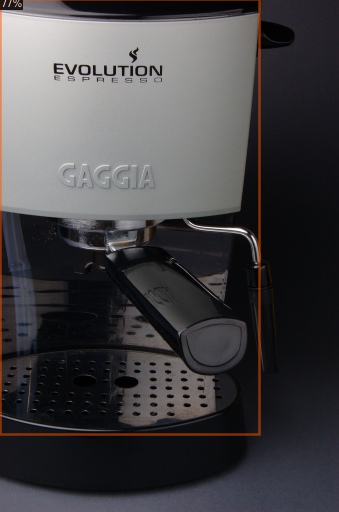

In [0]:
from detectron2.utils.visualizer import ColorMode
#dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(val_img_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=coffee_metadata, 
                   scale=0.5 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

## Evaluation

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70%. Not bad!

In [0]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("coffeemaker-validation", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "coffeemaker-validation")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [03/02 06:28:32 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'coffeemaker-validation'. Trying to convert it to COCO format ...
[03/02 06:28:32 d2.data.datasets.coco]: Converting dataset annotations in 'coffeemaker-validation' to COCO format ...)
Using validation for annotations...
On dataset: validation
Classes we're using: Coffeemaker    21
Name: ClassName, dtype: int64
[03/02 06:28:33 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/02 06:28:33 d2.data.datasets.coco]: Conversion finished, num images: 20, num annotations: 21
[03/02 06:28:33 d2.data.datasets.coco]: Caching annotations in COCO format: ./output/coffeemaker-validation_coco_format.json
Using validation for annotations...
On dataset: validation
Classes we're using: Coffeemaker    21
Name: ClassName, dtype: int64
[03/02 06:28:33 d2.data.build]: Distribution of instances among all 1 categories:
|  category   | #instances   |
|:-----------:|:-------------|
| Coffee

OrderedDict([('bbox',
              {'AP': 46.294068564818126,
               'AP50': 84.63833480122204,
               'AP75': 43.8896475854482,
               'APl': 46.294798726329844,
               'APm': nan,
               'APs': nan})])

## plain_train_net.py 

I'm going to write out the plain_train_net.py script verbatim to see what it's doing.

https://github.com/facebookresearch/detectron2/blob/master/tools/plain_train_net.py

I'll leave notes and change it where I need to.

In [0]:
# Different models I'd like to try - https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md
models_to_try = {
    "R50-FPN-1x": "COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml",
    "R50-FPN-3x": "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",
    "R101-FPN-3x": "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml",
    "X101-FPN-3x": "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml",
    "RN-R50-1x": "COCO-Detection/retinanet_R_50_FPN_1x.yaml",
    "RN-R50-3x": "COCO-Detection/retinanet_R_50_FPN_3x.yaml",
    "RN-R101-3x": "COCO-Detection/retinanet_R_101_FPN_3x.yaml"
}

In [0]:
import logging
import os
import argparse
from collections import OrderedDict
import pandas as pd
import numpy as np
import torch
from torch.nn.parallel import DistributedDataParallel

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.engine import default_argument_parser, default_setup, launch
from detectron2.evaluation import ( ### Changes from original, I don't need all the different evaluators
    COCOEvaluator,
    DatasetEvaluators,
    inference_on_dataset,
    print_csv_format
)
from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer
# Not sure what these do but they may help to track experiments
from detectron2.utils.events import (
    CommonMetricPrinter,
    EventStorage,
    JSONWriter,
    TensorboardXWriter
)

# Setup logger
logger = logging.getLogger("detectron2")

In [0]:
!nvidia-smi

Fri Mar  6 04:09:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Initialize Weights & Biases
import wandb
wandb.init(project="airbnb-object-detection", 
           sync_tensorboard=True)

## Register dataset
Before I can train a model I've got to register a dataset in Detectron2 style: https://detectron2.readthedocs.io/tutorials/datasets.html#register-a-dataset

This will leverage my preprocessing functions.

**Note:** Be sure to update the config for new datasets: https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets

In [0]:
# Setup training and validation data paths
train_path = "/content/drive/My Drive/Airbnb/coffeemaker-train"
valid_path = "/content/drive/My Drive/Airbnb/coffeemaker-validation"

In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog

In [0]:
def register_datasets(train_path, valid_path=None):
  """
  Registers a Detectron2 style dataset from training paths.

  Params
  ------
  train_path (str) : pathname to training data containing training images
  valid_path (str) : pathname to validation data containing validation images
  """
  # TODO - update to accept any kind of path, e.g. not only coffeemaker, maybe could take a dict as input?
  # E.g. {"training": "path/to/training",
  #          "valid": "path/to/valid"}
  for d in [train_path, valid_path]:
    print("Registering: {}".format(d.split("/")[-1]))
    DatasetCatalog.register(d.split("/")[-1], lambda d=d: get_image_dicts(d))
    MetadataCatalog.get(d.split("/")[-1]).set(thing_classes=["Coffeemaker"]) # TODO - this could be more robust than hard-coded
  return MetadataCatalog.get("coffeemaker-validation") # TODO - make this better

In [0]:
coffee_metadata = register_datasets(train_path=train_path,
                                    valid_path=valid_path)

Registering: coffeemaker-train
Registering: coffeemaker-validation


In [0]:
# Check registered dataset
DatasetCatalog._REGISTERED

{'cityscapes_fine_instance_seg_test': <function detectron2.data.datasets.builtin.register_all_cityscapes.<locals>.<lambda>>,
 'cityscapes_fine_instance_seg_train': <function detectron2.data.datasets.builtin.register_all_cityscapes.<locals>.<lambda>>,
 'cityscapes_fine_instance_seg_val': <function detectron2.data.datasets.builtin.register_all_cityscapes.<locals>.<lambda>>,
 'cityscapes_fine_sem_seg_test': <function detectron2.data.datasets.builtin.register_all_cityscapes.<locals>.<lambda>>,
 'cityscapes_fine_sem_seg_train': <function detectron2.data.datasets.builtin.register_all_cityscapes.<locals>.<lambda>>,
 'cityscapes_fine_sem_seg_val': <function detectron2.data.datasets.builtin.register_all_cityscapes.<locals>.<lambda>>,
 'coco_2014_minival': <function detectron2.data.datasets.register_coco.register_coco_instances.<locals>.<lambda>>,
 'coco_2014_minival_100': <function detectron2.data.datasets.register_coco.register_coco_instances.<locals>.<lambda>>,
 'coco_2014_train': <function d

In [0]:
# ### ORIGINAL REGISTER CODE

# for d in [valid_path, train_path]:
#     print("Registering: {}".format(d.split("/")[-1]))
#     DatasetCatalog.register(d.split("/")[-1], lambda d=d: get_image_dicts(d))
#     MetadataCatalog.get(d.split("/")[-1]).set(thing_classes=["Coffeemaker"])
# coffee_metadata = MetadataCatalog.get("coffeemaker-validation")

## TODO - Visualize dataset

Once you've got a dataset registered with Detectron2 it's a good idea to be able to visualize an image.

In [0]:
val_img_dicts[0]

{'annotations': [{'bbox': [185.0, 9.0, 800.0, 1024.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0}],
 'file_name': '/content/drive/My Drive/Airbnb/coffeemaker-validation/aa9b35d1bee25627.jpg',
 'height': 1024,
 'image_id': 0,
 'width': 1024}

{'file_name': '/content/drive/My Drive/Airbnb/coffeemaker-validation/d0dd806989582fe0.jpg', 'image_id': 10, 'height': 691, 'width': 1024, 'annotations': [{'bbox': [362.0, 8.0, 764.0, 656.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}]}


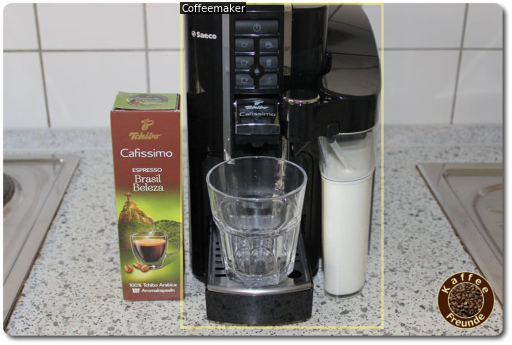

In [0]:
for d in random.sample(val_img_dicts, 1):
    print(d)
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=coffee_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train

The following code is original training code from the Detectron2 example notebook but I think we can make it better/suit our problem.

In [0]:
# Example use case of model_zoo
model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")

'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl'

In [0]:
# ### Original Training Code ###
# from detectron2.engine import DefaultTrainer
# from detectron2.config import get_cfg

# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
# cfg.DATASETS.TRAIN = ("coffeemaker-train",)
# cfg.DATASETS.TEST = ()
# cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")  # Let training initialize from model zoo
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
# cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (coffeemaker)

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg) 
# trainer.resume_or_load(resume=False)

In [0]:
default_config = get_cfg()
default_config.DATASETS.TRAIN = ("my-training-data",)
default_config.DATASETS

CfgNode({'TRAIN': 'my-training-data', 'PROPOSAL_FILES_TRAIN': (), 'PRECOMPUTED_PROPOSAL_TOPK_TRAIN': 2000, 'TEST': (), 'PROPOSAL_FILES_TEST': (), 'PRECOMPUTED_PROPOSAL_TOPK_TEST': 1000})

In [0]:
# Changed from original: Create evaluator for COCOEvaluator only 
# Since we are only using bounding boxes to begin with, our evaluator can be simple COCO style
def get_evaluator(cfg, dataset_name, output_folder=None):
  """
  Create a COCOEvaluator
  """
  if output_folder is None:
    output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
  evaluator = COCOEvaluator(
      dataset_name=dataset_name,
      cfg=cfg,
      distributed=False,
      output_dir=output_folder
  )
  return evaluator

In [0]:
# Create testing function
def do_test(cfg, model):
  results = OrderedDict()
  for dataset_name in cfg.DATASETS.TEST:
    data_loader = build_detection_test_loader(cfg, dataset_name)
    # Create the evaluator
    evaluator = get_evaluator(
        cfg, 
        dataset_name,
        output_folder=os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
    )
    # Make inference on dataset
    results_i = inference_on_dataset(model,
                                     data_loader,
                                     evaluator)
    # Update results dictionary
    results[dataset_name] = results_i

    print("### Returning results_i...")
    print(results_i)
    #print(f"### Average Precision: {results_i['AP']}")
    # Let's get some communication happening
    if comm.is_main_process():
      logger.info("Evaluation results for {} in csv format:".format(dataset_name))
      ## wandb.log()? TODO/NOTE: This may be something Weights & Biases can track
      print("### Calculating results...")
      print_csv_format(results_i)
    
    # Check to see length of results
    if len(results) == 1:
      results = list(results.values())[0]
    print("### Returning results...")
    print(results)

    # TODO : log results_i dict with different parameters
    print("### Saving results to Weights & Biases...")
    wandb.log(results_i)

    return results


Source code for Checkpointer: https://detectron2.readthedocs.io/_modules/fvcore/common/checkpoint.html

Maybe information from the Checkpointers can be saved to Weights & Biases? Or at least used to track in my own tracking.

In [0]:
# Create training function
def do_train(cfg, model, resume=False):
  # Set model to training mode
  model.train()
  # Create optimizer from config file (returns torch.nn.optimizer.Optimizer)
  optimizer = build_optimizer(cfg, model)
  # Create scheduler for learning rate (returns torch.optim.lr._LR_scheduler)
  scheduler = build_lr_scheduler(cfg, optimizer)

  # Create checkpointer
  checkpointer = DetectionCheckpointer(
      model, save_dir=cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
  )

  # Create start iteration (refernces checkpointer) - https://detectron2.readthedocs.io/modules/checkpoint.html#detectron2.checkpoint.Checkpointer.resume_or_load
  start_iter = (
      # This can be 0
      checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, # Use predefined model weights (pretrained model)
                                  resume=resume).get("iteration", -1) + 1
  )
  # Set max number of iterations
  max_iter = cfg.SOLVER.MAX_ITER

  # Create periodiccheckpoint
  periodic_checkpointer = PeriodicCheckpointer(checkpointer=checkpointer,
                                               # How often to make checkpoints?
                                               period=cfg.SOLVER.CHECKPOINT_PERIOD,
                                               max_iter=max_iter)
  
  # Create writers (for saving checkpoints?)
  writers = (
      [
       # Print out common metrics such as iteration time, ETA, memory, all losses, learning rate
       CommonMetricPrinter(max_iter=max_iter),
       # Write scalars to a JSON file such as loss values, time and more
       JSONWriter(os.path.join(cfg.OUTPUT_DIR, "metrics.json")),
       # Write all scalars such as loss values to a TensorBoard file for easy visualization
       TensorboardXWriter(cfg.OUTPUT_DIR),
      ]
      if comm.is_main_process()
      else []
  )

  ### Original note from script: ###
  # compared to "train_net.py", we do not support accurate timing and precise BN
  # here, because they are not trivial to implement

  # Build a training data loader based off the training dataset name in the config
  data_loader = build_detection_train_loader(cfg)

  # Start logging
  logger.info("Starting training from iteration {}".format(start_iter))

  # Store events
  with EventStorage(start_iter) as storage:
    # Loop through zipped data loader and iteration
    for data, iteration in zip(data_loader, range(start_iter, max_iter)):
      iteration = iteration + 1
      storage.step() # update stroage with step - https://detectron2.readthedocs.io/modules/utils.html#detectron2.utils.events.EventStorage.step

      # Create loss dictionary by trying to model data
      loss_dict = model(data)
      losses = sum(loss_dict.values())
      # Are losses infinite? If so, something is wrong
      assert torch.isfinite(losses).all(), loss_dict

      # TODO - Not quite sure what's happening here
      loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
      # Sum up losses
      losses_reduced = sum(loss for loss in loss_dict_reduced.values())
      
      # # TODO: wandb.log()? log the losses
      # wandb.log({
      #     "Total loss": losses_reduced
      # })

      # Update storage
      if comm.is_main_process():
        # Store informate in storage - https://detectron2.readthedocs.io/modules/utils.html#detectron2.utils.events.EventStorage.put_scalars
        storage.put_scalars(total_loss=losses_reduced,
                            **loss_dict_reduced)
      
      # Start doing PyTorch things
      optimizer.zero_grad()
      losses.backward()
      optimizer.step()
      # Add learning rate to storage information
      storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)

      # Perform evaluation?
      if (
          cfg.TEST.EVAL_PERIOD > 0
          and iteration % cfg.TEST.EVAL_PERIOD == 0
          and iteration != max_iter
      ):
          do_test(cfg, model)
          # TODO - compared to "train_net.py", the test results are not dumped to EventStorage
          comm.synchronize()
      
      # Log different metrics with writers
      if iteration - start_iter > 5 and (iteration % 20 == 0 or iteration == max_iter):
        for writer in writers:
          writer.write()
      
      # Update the periodic_checkpointer
      periodic_checkpointer.step(iteration)

In [0]:
# Create setup function
def setup(args):
  """
  Create configs and perform basic setups.
  """
  cfg = get_cfg()
  cfg.merge_from_file(args.config_file) # This will take some kind of model.yaml file
  cfg.merge_from_list(args.opts)
  cfg.freeze()
  default_setup(
      cfg, args
  ) # this logs the config and arguments passed to the command line to the output file

  # Load config YAML as dict
  cfg_yaml = cfg.load_yaml_with_base(os.path.join(cfg.OUTPUT_DIR, "config.yaml"))

  # default_config = get_cfg()
  # default_config_loaded = default_config.load_yaml_with_base("output/config.yaml")
  # default_config_loaded

  # TODO: turn config into YAML and save to weights & biases
  # TODO: Init wandb and add configs
  # Setup a new weights & biases run every time we run the setup() function
  wandb.init(project="airbnb-object-detection", 
            sync_tensorboard=True)
  print("### Printing config_yaml file to go into Weights & Biases")
  print(cfg_yaml)
  wandb.config.update(cfg_yaml)
  return cfg

In [0]:
# Create main function
def main(args):
  
  # Create the config file
  cfg = setup(args)

  # Build the model
  model = build_model(cfg)
  
  # Log what's going on
  logger.info("Model:\n{}".format(model))

  # TODO: Fix this (if it doesn't work)
  #wandb.watch(model, log="all")

  # Only do evaluation if the args say so
  if args.eval_only:
    DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
        cfg.MODEL.WEIGHTS, resume=args.resume
    )
    return do_test(cfg, model)

  # Do distributed training? (depends on number of GPUs available)
  distributed = comm.get_world_size() > 1
  if distributed:
    # Put the model on multiple devices if available
    model = DistributedDataParallel(
        model, 
        device_ids=[comm.get_local_rank()], 
        broadcast_buffers=False
    )

  # Train the model
  do_train(cfg, model)
  # TODO - May want to evaluate in a different step?
  return do_test(cfg, model)

In [0]:
models_to_try

{'R101-FPN-3x': 'COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml',
 'R50-FPN-1x': 'COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml',
 'R50-FPN-3x': 'COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml',
 'RN-R101-3x': 'COCO-Detection/retinanet_R_101_FPN_3x.yaml',
 'RN-R50-1x': 'COCO-Detection/retinanet_R_50_FPN_1x.yaml',
 'RN-R50-3x': 'COCO-Detection/retinanet_R_50_FPN_3x.yaml',
 'X101-FPN-3x': 'COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml'}

In [0]:
models_to_try["R50-FPN-1x"]

'COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml'

In [0]:
model_zoo.get_checkpoint_url('COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml')

'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl'

In [0]:
model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")

'/usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml'

Let's use a MAX_ITER of ~30 whilst we're building a small model.

We'll also change some defaults:
* `SOLVER.IMS_PER_BATCH` = 16 -> 2 (lower for memory issues)
* `DATALOADER.NUM_WORKERS` = 4 -> 2 (lower for memory issues)

These lowering settings are based on the example Detectron2 tutorial notebook (which runs in Colab), we can update them later once we figure out what resources we're using.

See this post for an example of resource use: https://lambdalabs.com/blog/weights-and-bias-gpu-cpu-utilization/

In [0]:
# Setup arg parser
parser = default_argument_parser() # default in Detectron2
args = parser.parse_args("--config-file /usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml \
                          MODEL.WEIGHTS https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl \
                          DATASETS.TRAIN ('coffeemaker-train',) \
                          DATASETS.TEST ('coffeemaker-validation',) \
                          DATALOADER.NUM_WORKERS 2 \
                          SOLVER.IMS_PER_BATCH 2 \
                          SOLVER.MAX_ITER 500 \
                          MODEL.ROI_HEADS.NUM_CLASSES 1".split())
# TODO: Add args to Weights & Biases
args

Namespace(config_file='/usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml', dist_url='tcp://127.0.0.1:49152', eval_only=False, machine_rank=0, num_gpus=1, num_machines=1, opts=['MODEL.WEIGHTS', 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl', 'DATASETS.TRAIN', "('coffeemaker-train',)", 'DATASETS.TEST', "('coffeemaker-validation',)", 'DATALOADER.NUM_WORKERS', '2', 'SOLVER.IMS_PER_BATCH', '2', 'SOLVER.MAX_ITER', '500', 'MODEL.ROI_HEADS.NUM_CLASSES', '1'], resume=False)

## Run custom training loop

In [0]:
if __name__ == "__main__":
  main(args)

[03/11 06:17:11 detectron2]: Rank of current process: 0. World size: 1
[03/11 06:17:11 detectron2]: Rank of current process: 0. World size: 1
[03/11 06:17:12 detectron2]: Environment info:
------------------------  ---------------------------------------------------------------
sys.platform              linux
Python                    3.6.9 (default, Nov  7 2019, 10:44:02) [GCC 8.3.0]
numpy                     1.17.5
detectron2                0.1.1 @/usr/local/lib/python3.6/dist-packages/detectron2
detectron2 compiler       GCC 7.3
detectron2 CUDA compiler  10.0
detectron2 arch flags     sm_35, sm_37, sm_50, sm_52, sm_60, sm_61, sm_70, sm_75
DETECTRON2_ENV_MODULE     <not set>
PyTorch                   1.4.0+cu100 @/usr/local/lib/python3.6/dist-packages/torch
PyTorch debug build       False
CUDA available            True
GPU 0                     Tesla T4
CUDA_HOME                 /usr/local/cuda
NVCC                      Cuda compilation tools, release 10.0, V10.0.130
Pillow          

### Printing config_yaml file to go into Weights & Biases
{'CUDNN_BENCHMARK': False, 'DATALOADER': {'ASPECT_RATIO_GROUPING': True, 'FILTER_EMPTY_ANNOTATIONS': True, 'NUM_WORKERS': 2, 'REPEAT_THRESHOLD': 0.0, 'SAMPLER_TRAIN': 'TrainingSampler'}, 'DATASETS': {'PRECOMPUTED_PROPOSAL_TOPK_TEST': 1000, 'PRECOMPUTED_PROPOSAL_TOPK_TRAIN': 2000, 'PROPOSAL_FILES_TEST': [], 'PROPOSAL_FILES_TRAIN': [], 'TEST': ['coffeemaker-validation'], 'TRAIN': ['coffeemaker-train']}, 'GLOBAL': {'HACK': 1.0}, 'INPUT': {'CROP': {'ENABLED': False, 'SIZE': [0.9, 0.9], 'TYPE': 'relative_range'}, 'FORMAT': 'BGR', 'MASK_FORMAT': 'polygon', 'MAX_SIZE_TEST': 1333, 'MAX_SIZE_TRAIN': 1333, 'MIN_SIZE_TEST': 800, 'MIN_SIZE_TRAIN': [640, 672, 704, 736, 768, 800], 'MIN_SIZE_TRAIN_SAMPLING': 'choice'}, 'MODEL': {'ANCHOR_GENERATOR': {'ANGLES': [[-90, 0, 90]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'NAME': 'DefaultAnchorGenerator', 'OFFSET': 0.0, 'SIZES': [[32], [64], [128], [256], [512]]}, 'BACKBONE': {'FREEZE_AT': 2, 'NAME': 'bui

model_final_b275ba.pkl: 167MB [00:19, 8.69MB/s]                           

[03/11 06:17:37 fvcore.common.download]: Successfully downloaded /root/.torch/fvcore_cache/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl. 167266879 bytes.
[03/11 06:17:37 fvcore.common.file_io]: URL https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl cached in /root/.torch/fvcore_cache/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl
[03/11 06:17:37 fvcore.common.checkpoint]: Reading a file from 'Detectron2 Model Zoo'
WARNING [03/11 06:17:37 fvcore.common.checkpoint]: 'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
WARNING [03/11 06:17:37 fvcore.common.checkpoint]: 'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
WARNING [03/11 06:17:37 fvcore.common.checkpoint]: 'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) i

[03/11 06:17:37 fvcore.common.checkpoint]: Some model parameters are not in the checkpoint:
  roi_heads.box_predictor.cls_score.{weight, bias}
  roi_heads.box_predictor.bbox_pred.{weight, bias}
Using train for annotations...
On dataset: train
Classes we're using: Coffeemaker    323
Name: ClassName, dtype: int64
[03/11 06:18:01 d2.data.build]: Removed 0 images with no usable annotations. 233 images left.
[03/11 06:18:01 d2.data.build]: Removed 0 images with no usable annotations. 233 images left.
[03/11 06:18:02 d2.data.build]: Distribution of instances among all 1 categories:
|  category   | #instances   |
|:-----------:|:-------------|
| Coffeemaker | 323          |
|             |              |
[03/11 06:18:02 d2.data.build]: Distribution of instances among all 1 categories:
|  category   | #instances   |
|:-----------:|:-------------|
| Coffeemaker | 323          |
|             |              |
[03/11 06:18:02 d2.data.common]: Serializing 233 elements to byte tensors and concatena

In [0]:
results_dict = OrderedDict([('bbox', 
                             {'AP': 0.421105753554186, 
                              'AP50': 2.570381670807977, 
                              'AP75': 0.0034985830738550883, 
                              'APs': None, 
                              'APm': None, 
                              'APl': 0.5861111021958075})])
results_dict["bbox"]["AP"]

0.421105753554186

# SUCCESS!!!!!!!

Model trained with a custom training loop! Now to figure out how to track experiments....

In [0]:
!nvidia-smi

Fri Mar  6 04:01:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    35W / 250W |   4075MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# if __name__ == "__main__":
#   # Creates an argument parser with common arguments used by Detectron2
#   args = default_argument_parser().parse_args()
#   print("Command Line Args:", args)
#   # Abstracted funciton for launching the main() function with a bunch of different things
#   launch(
#       main,
#       args.num_gpus,
#       num_machines=args.num_machines,
#       machine_rank=args.machine_rank,
#       dist_url=args.dist_url,
#       args=(args,),
#   )

usage: ipykernel_launcher.py [-h] [--config-file FILE] [--resume]
                             [--eval-only] [--num-gpus NUM_GPUS]
                             [--num-machines NUM_MACHINES]
                             [--machine-rank MACHINE_RANK]
                             [--dist-url DIST_URL]
                             ...
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [0]:
default_config = get_cfg()
default_config.SOLVER.CHECKPOINT_PERIOD

5000

In [0]:
# Checkout the contents of a default config file
default_config.dump()

"CUDNN_BENCHMARK: false\nDATALOADER:\n  ASPECT_RATIO_GROUPING: true\n  FILTER_EMPTY_ANNOTATIONS: true\n  NUM_WORKERS: 4\n  REPEAT_THRESHOLD: 0.0\n  SAMPLER_TRAIN: TrainingSampler\nDATASETS:\n  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000\n  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000\n  PROPOSAL_FILES_TEST: []\n  PROPOSAL_FILES_TRAIN: []\n  TEST: []\n  TRAIN: []\nGLOBAL:\n  HACK: 1.0\nINPUT:\n  CROP:\n    ENABLED: false\n    SIZE:\n    - 0.9\n    - 0.9\n    TYPE: relative_range\n  FORMAT: BGR\n  MASK_FORMAT: polygon\n  MAX_SIZE_TEST: 1333\n  MAX_SIZE_TRAIN: 1333\n  MIN_SIZE_TEST: 800\n  MIN_SIZE_TRAIN:\n  - 800\n  MIN_SIZE_TRAIN_SAMPLING: choice\nMODEL:\n  ANCHOR_GENERATOR:\n    ANGLES:\n    - - -90\n      - 0\n      - 90\n    ASPECT_RATIOS:\n    - - 0.5\n      - 1.0\n      - 2.0\n    NAME: DefaultAnchorGenerator\n    OFFSET: 0.0\n    SIZES:\n    - - 32\n      - 64\n      - 128\n      - 256\n      - 512\n  BACKBONE:\n    FREEZE_AT: 2\n    NAME: build_resnet_backbone\n  DEVICE: cuda\n  FPN:\n    FUSE

In [0]:
default_config = get_cfg()
default_config_loaded = default_config.load_yaml_with_base("output/config.yaml")
default_config_loaded

{'CUDNN_BENCHMARK': False,
 'DATALOADER': {'ASPECT_RATIO_GROUPING': True,
  'FILTER_EMPTY_ANNOTATIONS': True,
  'NUM_WORKERS': 2,
  'REPEAT_THRESHOLD': 0.0,
  'SAMPLER_TRAIN': 'TrainingSampler'},
 'DATASETS': {'PRECOMPUTED_PROPOSAL_TOPK_TEST': 1000,
  'PRECOMPUTED_PROPOSAL_TOPK_TRAIN': 2000,
  'PROPOSAL_FILES_TEST': [],
  'PROPOSAL_FILES_TRAIN': [],
  'TEST': ['coffeemaker-validation'],
  'TRAIN': ['coffeemaker-train']},
 'GLOBAL': {'HACK': 1.0},
 'INPUT': {'CROP': {'ENABLED': False,
   'SIZE': [0.9, 0.9],
   'TYPE': 'relative_range'},
  'FORMAT': 'BGR',
  'MASK_FORMAT': 'polygon',
  'MAX_SIZE_TEST': 1333,
  'MAX_SIZE_TRAIN': 1333,
  'MIN_SIZE_TEST': 800,
  'MIN_SIZE_TRAIN': [640, 672, 704, 736, 768, 800],
  'MIN_SIZE_TRAIN_SAMPLING': 'choice'},
 'MODEL': {'ANCHOR_GENERATOR': {'ANGLES': [[-90, 0, 90]],
   'ASPECT_RATIOS': [[0.5, 1.0, 2.0]],
   'NAME': 'DefaultAnchorGenerator',
   'OFFSET': 0.0,
   'SIZES': [[32], [64], [128], [256], [512]]},
  'BACKBONE': {'FREEZE_AT': 2, 'NAME': 'buil